### 173 samples, Final_R is missing for the following sample
137)	MC	air	204	8	180	60	180	500	30	114	0.3	NA	150	0.3	100	0.490196078	486.395	57.78712883	26.00664167	0.467	9.68631173	3	0.422680412	0.541775715	0.521526486	44.36424367

In [1]:
# Import Python libaries
%matplotlib inline
from scipy.optimize import curve_fit
import time as time
# General data management
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn import ensemble
from xgboost import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
# import pydo
# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)
# Machine learning & model visualization tools
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_gamma_deviance
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from numpy import cov
from scipy.stats import pearsonr
from scipy import ndimage, misc
import pydot
import math
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
# from sklearn.externals import joblib
# Miscellaneous
import os
import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as BK
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.inspection import partial_dependence, plot_partial_dependence

/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
2022-11-16 14:25:51.358258: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 14:25:51.358283: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# proxy properties
# read the input data
df = pd.read_csv('FJH_ML_Final.csv', header=1)
df_dummy = pd.get_dummies(df)

df['Norm_charge_tot'] = df['Charge_Tot']/(df['Mass'])*1000
df['Norm_I_Max'] = df['I_Max']/df['Mass']*1000
df['charge_density'] = df['Voltage']*df['Cap']/df['Mass']
df['Final_Current_Percent'] = df['I_Final']/df['I_Max']

Norm_I_Max = np.array (df['Norm_I_Max']).reshape(-1, 1)
Final_Current_Percent  = np.array (df['Final_Current_Percent']).reshape(-1, 1)
Norm_charge_tot  = np.array (df['Norm_charge_tot']).reshape(-1, 1)
# final prediction, yield of Graphene
Graphene_Yield = np.array (df['Graphene_Yield']).reshape(-1, 1)

# only process parameters that are in BO prediction
Pretreat_voltage = np.array (df['Pretreat_voltage']).reshape(-1, 1)
pulsetime = np.array (df['PulseTime']).reshape(-1, 1)
charge_denisty = np.array (df['charge_density']).reshape(-1, 1)

(-0.18993857418719323, 0.012062935912190395)

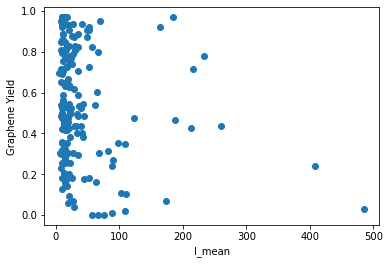

In [3]:
plt.scatter(df['I_Final'], df['Graphene_Yield'])
#plt.xlim(0, 1000)
plt.xlabel('I_mean');
plt.ylabel('Graphene Yield');

pearsonr(df['I_Final'], df['Graphene_Yield'])

/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

<AxesSubplot:xlabel='I_Final', ylabel='Density'>

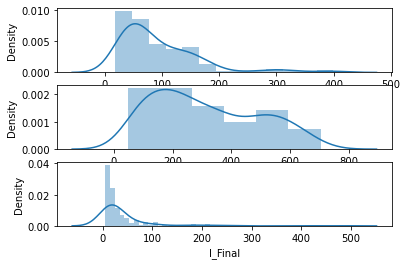

In [4]:
ax1 = plt.subplot(311)
sns.distplot (df['I_Mean'])
# add a subplot with no frame
ax2 = plt.subplot(312)
sns.distplot (df['I_Max']) 

ax3 = plt.subplot(313)
sns.distplot (df['I_Final'])

In [5]:
scaler = MinMaxScaler()
scaler.fit(np.array(df['I_Max']).reshape(-1, 1))

print(scaler.data_max_)
norm01_I_Max = scaler.transform(np.array(df['I_Max']).reshape(-1, 1))

[703.4397]


(0.7050712167737786, 9.134003863410914e-08)

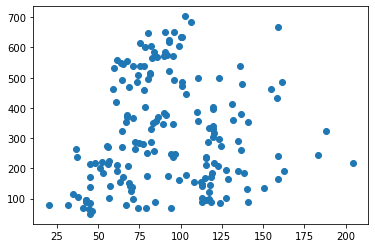

In [6]:
plt.scatter (df['charge_density'], df['I_Max'])
pearsonr(df['Voltage'][df['Material']=='MC'], df['I_Max'][df['Material']=='MC'])

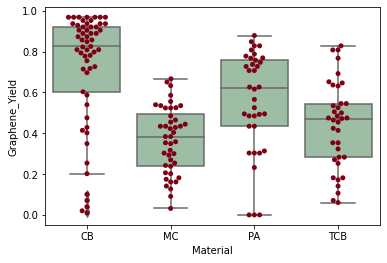

21.32217561441884 8.997595190802731e-12


In [7]:
# distribution of Voltage for different materials
import seaborn as sns
interest = 'Graphene_Yield'
ax = sns.boxplot(x='Material', y=interest, data=df, color='#99c2a2')
ax = sns.swarmplot(x="Material", y=interest, data=df, color='#7d0013')
plt.show()

import scipy.stats as stats
fvalue, pvalue = stats.f_oneway(
    df[interest].loc[df['Material']=='CB'], 
    df[interest].loc[df['Material']=='MC'], 
    df[interest].loc[df['Material']=='TCB'], 
    df[interest].loc[df['Material']=='PA']
)
print(fvalue, pvalue)

[703.4397]
r2_score:  0.24582338752044752


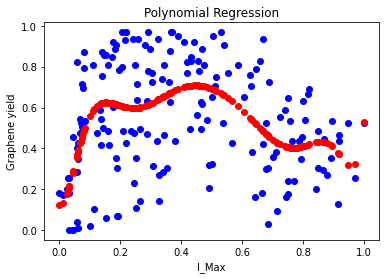

In [8]:
scaler = MinMaxScaler()
scaler.fit(np.array(df['I_Max']).reshape(-1, 1))

print(scaler.data_max_)
norm01_I_Max = scaler.transform(np.array(df['I_Max']).reshape(-1, 1))

#X = np.array(df['I_Max']).reshape(-1, 1)
X = norm01_I_Max
y= np.array (df['Graphene_Yield'])
poly = PolynomialFeatures(degree = 10)
X_poly = poly.fit_transform(X)
  
poly.fit(X_poly, y)
lin2 = LinearRegression()

lin2.fit(X_poly, y)
print ('r2_score: ', r2_score (y, lin2.predict(poly.fit_transform(X))))

plt.scatter(X, y, color = 'blue')
plt.scatter(X, lin2.predict(poly.fit_transform(X)), color = 'red')
plt.title('Polynomial Regression')
plt.xlabel('I_Max')
plt.ylabel('Graphene yield')
  
plt.show()

In [9]:
# mean (I_Final) = 40.8035 for the origianl dataset
# mean (I_Max) = 312.4003 for the origianl dataset
print ('mean (I_Final): ', np.mean(df['I_Final']))
print ('mean (I_Max): ', np.mean(df['I_Max']))

mean (I_Final):  40.80352983960345
mean (I_Max):  312.40027568965513


(0.34268553873628654, 3.680011667448526e-06)
(0.6090857528283636, 4.781351229742724e-19)


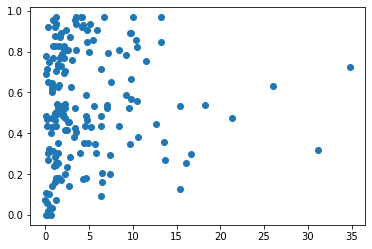

In [10]:
plt.scatter (df['Volt_Drop']/df['I_Mean']/df['Fin_R'], df['Graphene_Yield'])
print (pearsonr (df['Volt_Drop']/df['I_Mean'], df['Graphene_Yield']))
print (pearsonr (df['charge_density'], df['Graphene_Yield']))

In [11]:
# type of material
Material_CB = np.array (df_dummy['Material_CB']).reshape(-1, 1)
Material_MC = np.array (df_dummy['Material_MC']).reshape(-1, 1) 
Material_PA = np.array (df_dummy['Material_PA']).reshape(-1, 1)
Material_TCB = np.array (df_dummy['Material_TCB']).reshape(-1, 1)
material_type = np.concatenate ((Material_CB, Material_MC, Material_PA, Material_TCB), axis=1)

material_matrix = np.concatenate((np.array (df_dummy['Material_CB']).reshape([-1, 1]), 
                                  np.array (df_dummy['Material_MC']).reshape([-1, 1]),
                                  np.array (df_dummy['Material_PA']).reshape([-1, 1]),
                                  np.array (df_dummy['Material_TCB']).reshape([-1, 1])), axis=1)
material_matrix = np.array (material_matrix)
# extra material descriptors
# Cabot BP2000: Tensile Strength=17 MPa, particle size=15nm, specific surface area=1500(m2/g)
# metallurgical coke: grain size=150-210 (um)
# pyrolysis ash: 
# pyrolyzed rubber tire-derived carbon black: 

In [12]:
# physical properties of precursor received from Kevin
CB_ps_res_sa_sp2 = [45, 2.8, 1750, 41.2]
MC_ps_res_sa_sp2 = [150, 0.4, 18, 45.9]
PA_ps_res_sa_sp2 = [125, 7.2, 62, 42.4]
TCB_ps_res_sa_sp2 = [106, 6.3, 74, 30.6]
CB_MC_PA_TCB_ps_res_sa_sp2 = np.concatenate ([CB_ps_res_sa_sp2,
                 MC_ps_res_sa_sp2,
                 PA_ps_res_sa_sp2,
                 TCB_ps_res_sa_sp2], axis=0).reshape(4,4)
X_CB_MC_PA_TCB_ps_res_sa_sp2 = np.matmul(material_matrix, CB_MC_PA_TCB_ps_res_sa_sp2)

In [13]:
# type of Atmosphere
Atmosphere_air = np.array (df_dummy['Atmosphere_air']).reshape(-1, 1)
Atmosphere_arg = np.array (df_dummy['Atmosphere_arg']).reshape(-1, 1)
#Atmosphere_vac = np.array (df_dummy['Atmosphere_vac']).reshape(-1, 1)
atmosphere_type = np.concatenate ((Atmosphere_air, Atmosphere_arg), axis=1)

(0.6761394202756715, 6.011449257022206e-06)
(0.5223532228602892, 0.0010833533507464777)


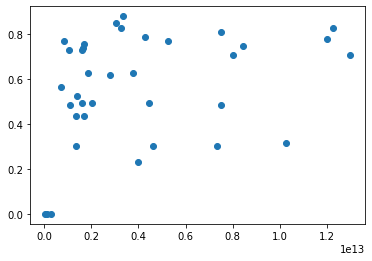

In [14]:
voltage_PA = df['Voltage'].loc[df['Material']=='PA']
mass_PA = df['Mass'].loc[df['Material']=='PA']
cap_PA = df['Cap'].loc[df['Material']=='PA']
GY_PA = df['Graphene_Yield'].loc[df['Material']=='PA']
CD_PA = df['charge_density'].loc[df['Material']=='PA']
prevol_PA = df['Pretreat_voltage'].loc[df['Material']=='PA']
prevolhighest_PA = df['Pretreat_voltage'].loc[df['Material']=='PA']
I_Max_PA = df['I_Max'].loc[df['Material']=='PA']
I_Mean_PA = df['I_Mean'].loc[df['Material']=='PA']
charge_tot_PA = df['Charge_Tot'].loc[df['Material']=='PA']

plt.scatter (((voltage_PA**1)/(mass_PA**-1)*(cap_PA**1))**3*1e-8
                +(prevol_PA**0.5) 
                +(I_Max_PA**0.8)
                +(charge_tot_PA**1)
                ,GY_PA)

print (pearsonr((voltage_PA**1)/(mass_PA**0.5)*(cap_PA**0.5) 
                +(prevol_PA**0.5) 
                +(I_Max_PA**0.8)
                +(charge_tot_PA**1)
                ,GY_PA))
print (pearsonr((voltage_PA**1)/(mass_PA**1)*cap_PA**1, GY_PA))

coef_:  [ 4.67884677e-02  8.71128908e-01  1.81185642e-01  4.76168053e-03
 -3.00632807e+01 -1.03729528e-01  4.17140823e-03  4.01314320e+10
  2.65031501e+10  1.45849424e+10 -5.18076893e+10]
(0.8156278626783328, 1.195474605526931e-06)
r-squared 0.6242327673759029
mse:  0.01971285302862217


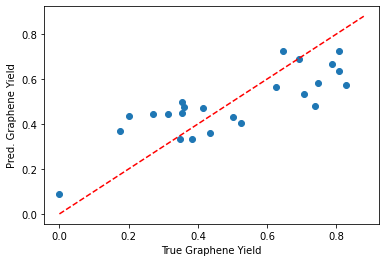

coef_:  [ 2.44130450e-01  7.33388492e-01  1.90817348e-01  4.70720032e-03
 -3.16298835e+01 -8.10656507e-02  7.57029042e-03  4.37657353e+09
  1.59902142e+09  1.81622937e+09 -5.32197152e+09]
(0.6927233169936737, 5.044258540082245e-18)
r-squared 0.4798597422850742
adj. r-squared 0.42536885814351055
mse:  0.0250931164828026
rmse:  0.15840806950027073
mae:  0.13037788544497864


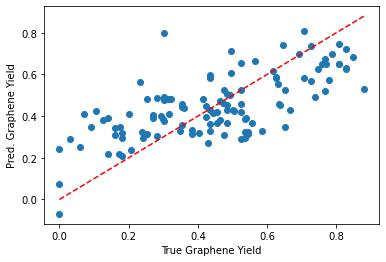

Text(0, 0.5, 'error of regression')

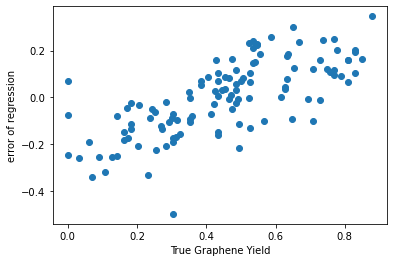

In [15]:
# linearly relate the input paramters to the final Graphene Yield
voltage_PA = np.array (df['Voltage'].loc[df['Material']!='CB']).reshape(-1, 1)
mass_PA = np.array (df['Mass'].loc[df['Material']!='CB']).reshape(-1, 1)
cap_PA = np.array (df['Cap'].loc[df['Material']!='CB']).reshape(-1, 1)
GY_PA = np.array (df['Graphene_Yield'].loc[df['Material']!='CB']).reshape(-1, 1)
CD_PA = np.array (df['charge_density'].loc[df['Material']!='CB']).reshape(-1, 1)
prevol_PA = np.array (df['Pretreat_voltage'].loc[df['Material']!='CB']).reshape(-1, 1)
prevolhighest_PA = np.array (df['Pretreat_voltage'].loc[df['Material']!='CB']).reshape(-1, 1)
I_Max_PA = np.array (df['I_Max'].loc[df['Material']!='CB']).reshape(-1, 1)
I_Mean_PA = np.array (df['I_Mean'].loc[df['Material']!='CB']).reshape(-1, 1)
charge_tot_PA = np.array (df['Charge_Tot'].loc[df['Material']!='CB']).reshape(-1, 1)
pulsetime_PA = np.array (df['PulseTime'].loc[df['Material']!='CB']).reshape(-1, 1)
maxima_PA = np.array (df['Maxima'].loc[df['Material']!='CB']).reshape(-1, 1)

input_features = np.concatenate(((voltage_PA**1*((mass_PA/100)**-1)*(cap_PA**1))**2*1e-9
                                 , (prevol_PA**0.5)*1e-2 
                                 , (I_Max_PA**0.8)*1e-2
                                 , pulsetime_PA**0.5
                                 , ((charge_tot_PA)**-2)*1e-2
                                 , mass_PA*1e-2 
                                 , cap_PA*1e-1
                                 , X_CB_MC_PA_TCB_ps_res_sa_sp2 [df['Material']!='CB']
                                   ), axis=1)

max_gamma_score = 0
for rand in range(0, 20):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, GY_PA, test_size=0.2, random_state=rand)
    clf = linear_model.LinearRegression(fit_intercept=True, positive=False)
    clf = clf.fit(X_train, y_train.ravel())
    if clf.score(X_test, y_test.ravel()) > max_gamma_score:
        max_gamma_score = clf.score(X_test, y_test.ravel())
        best_random_state = rand

X_train, X_test, y_train, y_test = train_test_split(
        input_features, GY_PA, test_size=0.2, random_state=best_random_state)
clf = linear_model.LinearRegression(fit_intercept=True, positive=False)
clf = clf.fit(X_train, y_train.ravel())
print ('coef_: ', clf.coef_)
y_pred = clf.predict (X_test)

print (pearsonr(y_test.ravel(), y_pred.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.xlabel('True Graphene Yield')
plt.ylabel('Pred. Graphene Yield')

mid_line = list(np.linspace(np.min(GY_PA), np.max(GY_PA), 8))
plt.plot(mid_line, mid_line, '--', color='red')
plt.show()


clf = clf.fit(input_features, GY_PA.ravel())
print ('coef_: ', clf.coef_)
y_pred = clf.predict (input_features)
print (pearsonr(GY_PA.ravel(), y_pred.ravel()))
r2 = r2_score(GY_PA.ravel(), y_pred.ravel())
print ('r-squared', r2)
n = input_features.shape[0]
p = input_features.shape[1]
Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print ('adj. r-squared', Adj_r2)
print ('mse: ', mean_squared_error(GY_PA, y_pred))
print ('rmse: ', np.sqrt(mean_squared_error(GY_PA, y_pred)))
print ('mae: ', mean_absolute_error(GY_PA, y_pred))


plt.scatter(GY_PA, y_pred)
plt.xlabel('True Graphene Yield')
plt.ylabel('Pred. Graphene Yield')
mid_line = list(np.linspace(np.min(GY_PA), np.max(GY_PA), 8))
plt.plot(mid_line, mid_line, '--', color='red')
plt.show()

error = GY_PA - y_pred.reshape(-1, 1)
plt.scatter (GY_PA, (error))
plt.xlabel('True Graphene Yield')
plt.ylabel('error of regression')

/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

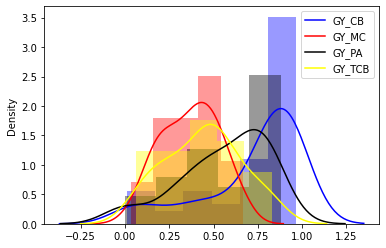

In [16]:
GY_CB = np.array (df['Graphene_Yield'].loc[df['Material'] =='CB']).reshape(-1, 1)
GY_MC = np.array (df['Graphene_Yield'].loc[df['Material'] =='MC']).reshape(-1, 1)
GY_PA = np.array (df['Graphene_Yield'].loc[df['Material'] =='PA']).reshape(-1, 1)
GY_TCB = np.array (df['Graphene_Yield'].loc[df['Material'] =='TCB']).reshape(-1, 1)

sns.distplot (GY_CB, color='blue')
sns.distplot (GY_MC, color='red')
sns.distplot (GY_PA, color='black')
sns.distplot (GY_TCB, color='yellow')
plt.legend(['GY_CB', 'GY_MC', 'GY_PA', 'GY_TCB'])

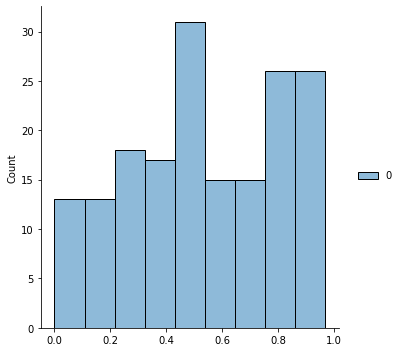

In [17]:
sns.displot (Graphene_Yield)

/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/linear_model/_glm/link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/linear_model/_glm/link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) 

coef_:  [ 0.85859558  1.26522421 -0.56475846 -0.85072293  0.1269714   0.00456508
 -0.01456464]
Gamma score: 0.6355407984639161
r-squared 0.4134282330137423
mse:  0.04719455569808928


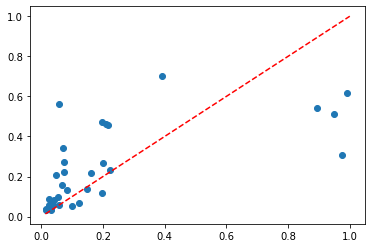

In [18]:
# Final_Current_Percent as output of linear model with inputs Precursor related
# Init_R, Res_Drop, Volt_Drop --> Final_Current_Percent
material_matrix_cosh = np.cosh (material_matrix)
Init_R = np.array (df['Init_R']).reshape (-1, 1)
Res_Drop = np.array (df['Res_Drop']).reshape (-1, 1)
Volt_Drop = np.array (df['Volt_Drop']).reshape (-1, 1)
Mass = np.array (df['Mass']).reshape(-1, 1)

input_features = np.concatenate((material_matrix_cosh, Init_R, Res_Drop, Volt_Drop), axis=1)
max_gamma_score = 0
for rand in range(0, 100):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, Final_Current_Percent, test_size=0.2, random_state=rand)
    clf = linear_model.GammaRegressor(alpha=0., max_iter=10000)
    clf = clf.fit(X_train, y_train.ravel())
    if clf.score(X_test, y_test.ravel()) > max_gamma_score:
        max_gamma_score = clf.score(X_test, y_test.ravel())
        best_random_state = rand

X_train, X_test, y_train, y_test = train_test_split(
        input_features, Final_Current_Percent, test_size=0.2, random_state=best_random_state)
clf = linear_model.GammaRegressor(alpha=0., max_iter=10000)
clf = clf.fit(X_train, y_train.ravel())
print ('coef_: ', clf.coef_)
CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0:4]
y_pred = clf.predict (X_test)
print ('Gamma score:', clf.score(X_test, y_test.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))


plt.scatter(y_test, y_pred)
mid_line = list(np.linspace(np.min(Final_Current_Percent), np.max(Final_Current_Percent), 8))
plt.plot(mid_line, mid_line, '--', color='red')

coef_:  [-0.12706507 -0.09505012  0.07616448 -0.26409503  0.00286348 -0.00347033
  0.00132296 -0.05904571 -0.02290511  0.00354556]
Gamma score for test data: 0.7109013005717477
r-squared for test data 0.7622299090934634
mse:  126323.37861240293


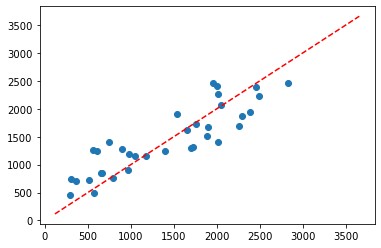

In [19]:
# Norm_I_Max as output of linear model with inputs Precursor related:
# Init_R, Res_Drop, Volt_Drop --> Norm_I_Max
input_features = np.concatenate((material_matrix_cosh, X_CB_MC_PA_TCB_ps_res_sa_sp2[:, (0, 1, 3)], 
                                 Init_R, Res_Drop, Volt_Drop), axis=1)
max_gamma_score = 0
for rand in range(0, 100):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_I_Max, test_size=0.2, random_state=rand)
    clf = linear_model.GammaRegressor(alpha=0., max_iter=10000)
    clf = clf.fit(X_train, y_train.ravel())
    if clf.score(X_test, y_test.ravel()) > max_gamma_score:
        max_gamma_score = clf.score(X_test, y_test.ravel())
        best_random_state = rand

X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_I_Max, test_size=0.2, random_state=best_random_state)
clf = linear_model.GammaRegressor(alpha=0., max_iter=10000)
clf = clf.fit(X_train, y_train.ravel())

print ('coef_: ', clf.coef_)
CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]
y_pred = clf.predict (X_test)
print ('Gamma score for test data:', clf.score(X_test, y_test.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared for test data', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))

plt.scatter(y_test, y_pred)
mid_line = list(np.linspace(np.min(Norm_I_Max), np.max(Norm_I_Max), 8))
plt.plot(mid_line, mid_line, '--', color='red')

coef_:  [-0.07910392 -0.32993873 -0.32547128 -0.20674004 -0.008548    0.01448827
  0.00882141]
Gamma score: 0.7773710858702431
r-squared 0.7372262579997564
mse:  309.3488773693205


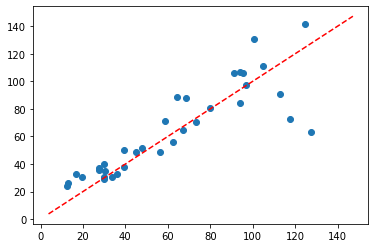

In [20]:
# Norm_charge_tot as output of linear model with inputs Precursor related
# Init_R, Res_Drop, Volt_Drop --> Norm_charge_tot
input_features = np.concatenate((material_matrix, Init_R, Res_Drop, Volt_Drop), axis=1)
max_gamma_score = 0
for rand in range(0, 100):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_charge_tot, test_size=0.2, random_state=rand)
    clf = linear_model.GammaRegressor(alpha=0., max_iter=1000)
    clf = clf.fit(X_train, y_train.ravel())
    if clf.score(X_test, y_test.ravel()) > max_gamma_score:
        max_gamma_score = clf.score(X_test, y_test.ravel())
        best_random_state = rand

X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_charge_tot, test_size=0.2, random_state=best_random_state)
clf = linear_model.GammaRegressor(alpha=0., max_iter=1000)
clf = clf.fit(X_train, y_train.ravel())
print ('coef_: ', clf.coef_)
CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0:4]
y_pred = clf.predict (X_test)
print ('Gamma score:', clf.score(X_test, y_test.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))


plt.scatter(y_test, y_pred)
mid_line = list(np.linspace(np.min(Norm_charge_tot), np.max(Norm_charge_tot), 8))
plt.plot(mid_line, mid_line, '--', color='red')

In [21]:
# got it from model based prediction of I_Max
material_type_I_Finalperc_coef = material_type * CB_MC_PA_coef_Final_Current_Percent
material_type_Norm_I_Max_coef = material_type * CB_MC_PA_coef_Norm_I_Max
material_type_Norm_charge_Tot_coef = material_type * CB_MC_PA_coef_Norm_charge_tot

In [22]:
# proxy (current-time plot) prediction (Final_Current_percent)
new_features = np.concatenate ((charge_denisty,
                                pulsetime,
                                material_type_I_Finalperc_coef,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=0
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Final_Current_Percent, 
                                       indices, test_size = 0.20, random_state = rand)
feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_CB',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Pretreat_voltage']
new_features[0]

array([ 1.12800000e+02,  1.20000000e+03,  8.58595584e-01,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.00000000e+01])

In [23]:
charge_denisty.shape

(174, 1)

In [24]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(50):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    xgbr_final_I_percent = XGBRegressor(max_depth=3, n_estimators=25, gamma=0.01, 
                   learning_rate=0.115, subsample=0.77, min_child_weight=8, 
                   random_state=random_state)
    #xgbr_final_I_percent = RandomForestRegressor(max_depth=20, n_estimators=500, min_samples_split=3)
    # xgbr_final_I_percent = linear_model.BayesianRidge()
    # xgbr_final_I_percent = XGBRegressor()
    # Train the model on training data
    labels = Final_Current_Percent
    xgbr_final_I_percent.fit(train_new_features, train_labels);
    #print('Doneskies')
    Final_Current_Percent_test = xgbr_final_I_percent.predict(test_new_features)
    r_squared_Final_Current_test = r2_score(test_labels, Final_Current_Percent_test)
    r_squareds.append(r_squared_Final_Current_test)
    
    r_pearson_Final_Current_test = pearsonr(test_labels.reshape(test_labels.shape[0],), 
                                            Final_Current_Percent_test.reshape(Final_Current_Percent_test.shape[0],))
    r_pearsons.append(r_pearson_Final_Current_test[0])   
    
    Final_Current_Percent_train = xgbr_final_I_percent.predict(train_new_features)
    r_squared_Final_Current_train = r2_score(train_labels, Final_Current_Percent_train)
    r_squareds_train.append(r_squared_Final_Current_train)    

print ('Average of r pearson for test', np.mean(np.array(r_pearsons)))
print ('std of r pearson for test', np.std(np.array(r_pearsons)), '\n')

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))

xgbr_final_I_percent.fit(new_features, labels)
# Use the forest's predict method on the test data
Final_Current_Percent_predicted = xgbr_final_I_percent.predict(new_features)
# Calculate the absolute errors
errors = abs(Final_Current_Percent_predicted - Final_Current_Percent)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Final_Current_all = r2_score(Final_Current_Percent, Final_Current_Percent_predicted)
print('r2 score = ', r_squared_Final_Current_all)

# Use the forest's predict method on the test data
Final_Current_Percent_test = xgbr_final_I_percent.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Final_Current_Percent_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Final_Current_test = r2_score(test_labels, Final_Current_Percent_test)
print('r2 score = ', r_squared_Final_Current_test)

Average of r pearson for test 0.7121996078082272
std of r pearson for test 0.016502181916879865 

Average of r_squared for test 0.482765645772217
std of r_squared for test 0.028407963803648514 

Average of r_squared for train 0.7893109433051783
std of r_squared for train 0.008087188736208735
Mean Absolute Error: 0.2072 units.
r2 score =  0.777848107305179
Mean Absolute Error: 0.1598 units.
r2 score =  0.7212958350290023


In [25]:
# Get numerical feature importances
importances = list(xgbr_final_I_percent.feature_importances_)
print (importances)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];

[0.07375926, 0.48786104, 0.06047855, 0.11870212, 0.0075992225, 0.037053633, 0.059584334, 0.0, 0.15496178]
Variable: charge_denisty Importance: ('charge_denisty', 0.07)
Variable: PulseTime Importance: ('PulseTime', 0.49)
Variable: material_CB Importance: ('material_CB', 0.06)
Variable: material_MC Importance: ('material_MC', 0.12)
Variable: material_PA Importance: ('material_PA', 0.01)
Variable: material_CB Importance: ('material_CB', 0.04)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.06)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.0)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.15)


In [26]:
# proxy (current-time plot) prediction (Norm_I_Max)
new_features = np.concatenate ((charge_denisty,
                                #np.array (df['Voltage']).reshape(-1, 1),
                                pulsetime,
                                material_type_Norm_I_Max_coef,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=0
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_I_Max, 
                                       indices, test_size = 0.2, random_state = rand)

feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_TCB',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Pretreat_voltage']

(0.7895080655700772, 1.731054934952032e-08)
Average of pearson r for test 0.7810154834756273
std of pearson 1 for test 0.01008559249330929 

Average of r_squared for test 0.573356679659293
std of r_squared for test 0.013405545283271307 

Average of r_squared for train 0.6920682071470152
std of r_squared for train 0.006170619174382692
Mean Absolute Error: 718.5204 units.
r2 score =  0.690673533208469
Mean Absolute Error: 715.1021 units.
r2 score =  0.692127316379529


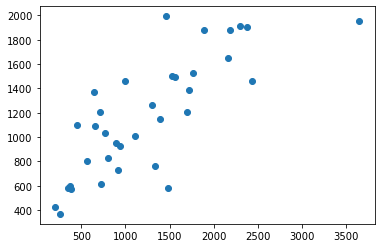

In [27]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(10):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    
    xgbr_norm_I_max = XGBRegressor(max_depth=3, n_estimators=25, gamma=0.001, 
                   learning_rate=0.09, subsample=0.775, min_child_weight=6, 
                  random_state=random_state)
    
    #xgbr_norm_I_max = RandomForestRegressor(max_depth=3, n_estimators=100, min_samples_split=3)
    # xgbr_norm_I_max = linear_model.BayesianRidge()
    # xgbr_norm_I_max = XGBRegressor()
    # Train the model on training data
    labels = Norm_I_Max
    xgbr_norm_I_max.fit(train_new_features, train_labels);
    
    Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
    r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)

    test_labels_ = test_labels.reshape(test_labels.shape[0], )

    Norm_I_Max_test_ = Norm_I_Max_test.reshape(Norm_I_Max_test.shape[0], )

    r_pearson_Norm_I_Max_test = pearsonr(test_labels_, Norm_I_Max_test_)
    r_pearsons.append(r_pearson_Norm_I_Max_test[0])
    r_squareds.append(r_squared_Norm_I_Max_test)
    
    Norm_I_Max_train = xgbr_norm_I_max.predict(train_new_features)
    r_squared_Norm_I_Max_train = r2_score(train_labels, Norm_I_Max_train)
    r_squareds_train.append(r_squared_Norm_I_Max_train)  

r_pearson_Norm_I_Max_test = pearsonr(test_labels_, Norm_I_Max_test_)
print (r_pearson_Norm_I_Max_test)
plt.scatter(test_labels_, Norm_I_Max_test_)
print ('Average of pearson r for test', np.mean(np.array(r_pearsons)))
print ('std of pearson 1 for test', np.std(np.array(r_pearsons)), '\n')
print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')
print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))

xgbr_norm_I_max.fit(new_features, labels)
# Use the forest's predict method on the test data
Norm_I_Max_predicted = xgbr_norm_I_max.predict(new_features)
# Calculate the absolute errors
errors = abs(Norm_I_Max_predicted - Norm_I_Max)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Norm_I_Max_all = r2_score(Norm_I_Max, Norm_I_Max_predicted)
print('r2 score = ', r_squared_Norm_I_Max_all)

# Use the forest's predict method on the test data
Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Norm_I_Max_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
print('r2 score = ', r_squared_Norm_I_Max_test)

In [28]:
# Get numerical feature importances
importances = list(xgbr_norm_I_max.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];
print (importances)

Variable: charge_denisty Importance: ('charge_denisty', 0.14)
Variable: PulseTime Importance: ('PulseTime', 0.03)
Variable: material_CB Importance: ('material_CB', 0.0)
Variable: material_MC Importance: ('material_MC', 0.55)
Variable: material_PA Importance: ('material_PA', 0.0)
Variable: material_TCB Importance: ('material_TCB', 0.06)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.0)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.09)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.14)
[0.14157231, 0.029698309, 0.0, 0.5455658, 0.0, 0.06243607, 0.0, 0.08547817, 0.13524945]


In [29]:
# proxy (current-time plot) prediction (Norm_Norm_charge_tot)
new_features = np.concatenate ((charge_denisty,
                                pulsetime,
                                material_type_Norm_charge_Tot_coef,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=0
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_charge_tot, 
                                       indices, test_size = 0.20, random_state = rand)
feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_TCB',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Pretreat_voltage']

In [30]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(10):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    xgbr_norm_charge_total = XGBRegressor(max_depth=10, n_estimators=100, gamma=0.01, 
                   learning_rate=0.118, subsample=0.75, min_child_weight=2, 
                  random_state=random_state)
    #xgbr_norm_charge_total = RandomForestRegressor(max_depth=5, n_estimators=200, min_samples_split=3)
    # xgbr_norm_charge_total = linear_model.BayesianRidge()
    # xgbr_norm_charge_total = XGBRegressor()
    # Train the model on training data
    labels = Norm_charge_tot
    xgbr_norm_charge_total.fit(train_new_features, train_labels);
    #print('Doneskies')
    Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
    r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
    r_squareds.append(r_squared_Norm_charge_tot_test)
    
    test_labels_ = test_labels.reshape(test_labels.shape[0], )
    Norm_charge_tot_test_ = Norm_charge_tot_test.reshape(Norm_charge_tot_test.shape[0], )
    r_pearson_Norm_charge_tot_test = pearsonr(test_labels_, Norm_charge_tot_test_)
    r_pearsons.append(r_pearson_Norm_charge_tot_test[0])

    
    Norm_charge_tot_train = xgbr_norm_charge_total.predict(train_new_features)
    r_squared_Norm_charge_tot_train = r2_score(train_labels, Norm_charge_tot_train)
    r_squareds_train.append(r_squared_Norm_charge_tot_train)    

print ('Average of pearson r for test', np.mean(np.array(r_pearsons)))
print ('std of pearson 1 for test', np.std(np.array(r_pearsons)), '\n')

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))


xgbr_norm_charge_total.fit(new_features, labels)
# Use the forest's predict method on the test data
Norm_charge_tot_predicted = xgbr_norm_charge_total.predict(new_features)
# Calculate the absolute errors
errors = abs(Norm_charge_tot_predicted - Norm_charge_tot)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Norm_charge_tot_all = r2_score(Norm_charge_tot, Norm_charge_tot_predicted)
print('r2 score = ', r_squared_Norm_charge_tot_all)

# Use the forest's predict method on the test data
Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Norm_charge_tot_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
print('r2 score = ', r_squared_Norm_charge_tot_test)

Average of pearson r for test 0.762857267170948
std of pearson 1 for test 0.02562412003965354 

Average of r_squared for test 0.5492208940617689
std of r_squared for test 0.034717596485303946 

Average of r_squared for train 0.9992018799936646
std of r_squared for train 0.00020163820884514097
Mean Absolute Error: 34.65 units.
r2 score =  0.9993209585434534
Mean Absolute Error: 37.4597 units.
r2 score =  0.9991980110720922


In [31]:
# Get numerical feature importances
importances = list(xgbr_norm_charge_total.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];

print (importances)

Variable: charge_denisty Importance: ('charge_denisty', 0.12)
Variable: PulseTime Importance: ('PulseTime', 0.13)
Variable: material_CB Importance: ('material_CB', 0.08)
Variable: material_MC Importance: ('material_MC', 0.22)
Variable: material_PA Importance: ('material_PA', 0.03)
Variable: material_TCB Importance: ('material_TCB', 0.18)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.06)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.09)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.1)
[0.11565813, 0.13434339, 0.07814488, 0.21513005, 0.02933864, 0.18005373, 0.06032598, 0.085444376, 0.101560794]


In [32]:
print (CB_MC_PA_coef_Final_Current_Percent)
print (CB_MC_PA_coef_Norm_I_Max)
print (CB_MC_PA_coef_Norm_charge_tot)
CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                             CB_MC_PA_coef_Norm_I_Max +
                             CB_MC_PA_coef_Norm_charge_tot)/3
print (CB_MC_PA_TCB_coef_average)

[ 0.85859558  1.26522421 -0.56475846 -0.85072293]
[-0.12706507 -0.09505012  0.07616448 -0.26409503]
[-0.07910392 -0.32993873 -0.32547128 -0.20674004]
[ 0.21747553  0.28007845 -0.27135508 -0.44051933]


coef_:  [ 9.08424128e-01  4.60149659e-01  2.20912710e-02  5.49016676e-03
  1.34490720e-01  4.36209430e-02 -6.93143732e-03 -1.35534749e-02
  2.37964732e-02 -5.04548281e-04  2.55184502e-02]
(0.808291599071205, 4.30496004306959e-09)
r-squared 0.6391703073244415
mse:  0.02249125966641459


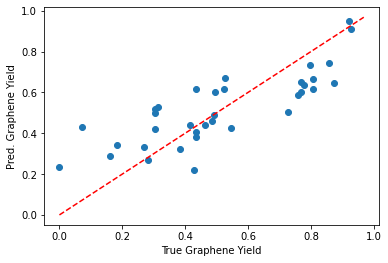

coef_:  [ 9.59641866e-01  9.51810841e-01  1.66744079e-02  5.25316467e-03
  1.46816811e-01  1.89868372e-02 -2.87146310e-03 -1.14242241e-02
  1.90227670e-02 -4.18080149e-04  2.00605327e-02]
(0.7510179691475158, 7.932790310418165e-33)
r-squared 0.5640279899824587
adj. r-squared 0.5344249522652182
mse:  0.032583862473766004
rmse:  0.1805100065751647
mae:  0.1507685296139118


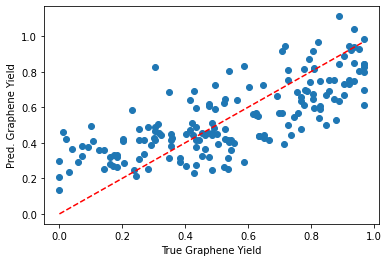

Text(0, 0.5, 'error of regression')

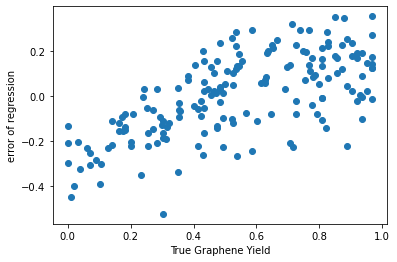

In [33]:
# linearly relate the input paramters to the final Graphene Yield
voltage_ALL = np.array (df['Voltage'].loc[df['Material']!='AAA']).reshape(-1, 1)
mass_ALL = np.array (df['Mass'].loc[df['Material']!='AAA']).reshape(-1, 1)
cap_ALL = np.array (df['Cap'].loc[df['Material']!='AAA']).reshape(-1, 1)
GY_ALL = np.array (df['Graphene_Yield'].loc[df['Material']!='AAA']).reshape(-1, 1)
CD_ALL = np.array (df['charge_density'].loc[df['Material']!='AAA']).reshape(-1, 1)
prevol_ALL = np.array (df['Pretreat_voltage'].loc[df['Material']!='AAA']).reshape(-1, 1)
prevolhighest_ALL = np.array (df['Pretreat_voltage'].loc[df['Material']!='AAA']).reshape(-1, 1)
I_Max_ALL = np.array (df['I_Max'].loc[df['Material']!='AAA']).reshape(-1, 1)
I_Mean_ALL = np.array (df['I_Mean'].loc[df['Material']!='AAA']).reshape(-1, 1)
charge_tot_ALL = np.array (df['Charge_Tot'].loc[df['Material']!='AAA']).reshape(-1, 1)
pulsetime_ALL = np.array (df['PulseTime'].loc[df['Material']!='AAA']).reshape(-1, 1)
maxima_ALL = np.array (df['Maxima'].loc[df['Material']!='AAA']).reshape(-1, 1)

                                #Final_Current_Percent_predicted.reshape(-1, 1),
                                #Norm_I_Max_predicted.reshape(-1, 1),
                                #Norm_charge_tot_predicted.reshape(-1, 1), 
            
input_features = np.concatenate(((voltage_ALL**1*((mass_ALL/100)**-1)*(cap_ALL**1))**2*1e-9
                                 , (prevol_ALL**0.5)*1e-2 
                                 , (Norm_I_Max_predicted.reshape(-1, 1)**1)*1e-2
                                 , pulsetime_ALL**0.5
                                 , ((Norm_charge_tot_predicted.reshape(-1, 1))**1)*1e-2
                                 , mass_ALL*1e-2 
                                 , cap_ALL*1e-1
                                 , X_CB_MC_PA_TCB_ps_res_sa_sp2 [df['Material']!='AAA']
                                   ), axis=1)

max_gamma_score = 0
for rand in range(0, 20):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, GY_ALL, test_size=0.2, random_state=rand)
    phys_reg_mdl = linear_model.LinearRegression(fit_intercept=True, positive=False)
    phys_reg_mdl = phys_reg_mdl.fit(X_train, y_train.ravel())
    if phys_reg_mdl.score(X_test, y_test.ravel()) > max_gamma_score:
        max_gamma_score = phys_reg_mdl.score(X_test, y_test.ravel())
        best_random_state = rand

X_train, X_test, y_train, y_test = train_test_split(
        input_features, GY_ALL, test_size=0.2, random_state=best_random_state)
phys_reg_mdl = linear_model.LinearRegression(fit_intercept=True, positive=False)
phys_reg_mdl = phys_reg_mdl.fit(X_train, y_train.ravel())
print ('coef_: ', phys_reg_mdl.coef_)
y_pred = phys_reg_mdl.predict (X_test)

print (pearsonr(y_test.ravel(), y_pred.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.xlabel('True Graphene Yield')
plt.ylabel('Pred. Graphene Yield')

mid_line = list(np.linspace(np.min(GY_ALL), np.max(GY_ALL), 8))
plt.plot(mid_line, mid_line, '--', color='red')
plt.show()


phys_reg_mdl = phys_reg_mdl.fit(input_features, GY_ALL.ravel())

print ('coef_: ', phys_reg_mdl.coef_)
y_pred = phys_reg_mdl.predict (input_features)
print (pearsonr(GY_ALL.ravel(), y_pred.ravel()))
r2 = r2_score(GY_ALL.ravel(), y_pred.ravel())
print ('r-squared', r2)
n = input_features.shape[0]
p = input_features.shape[1]
Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print ('adj. r-squared', Adj_r2)
print ('mse: ', mean_squared_error(GY_ALL, y_pred))
print ('rmse: ', np.sqrt(mean_squared_error(GY_ALL, y_pred)))
print ('mae: ', mean_absolute_error(GY_ALL, y_pred))


plt.scatter(GY_ALL, y_pred)
plt.xlabel('True Graphene Yield')
plt.ylabel('Pred. Graphene Yield')
mid_line = list(np.linspace(np.min(GY_ALL), np.max(GY_ALL), 8))
plt.plot(mid_line, mid_line, '--', color='red')
plt.show()

error = GY_ALL - y_pred.reshape(-1, 1)
plt.scatter (GY_ALL, (error))
plt.xlabel('True Graphene Yield')
plt.ylabel('error of regression')

In [171]:
# assume constant resisitivity for precursors
CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
resistance_matrix = np.matmul(material_matrix, CB_MC_PA_TCB_res)
heat_power = np.array (df['Voltage']*df['Voltage']/resistance_matrix*df['PulseTime']*(1e-6)).reshape(-1, 1)
# got it from model based prediction of I_Max
# got it from model based prediction of I_Max
CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                             CB_MC_PA_coef_Norm_I_Max +
                             CB_MC_PA_coef_Norm_charge_tot)/3

material_type_GY_coef = material_type * CB_MC_PA_TCB_coef_average
# Porxy properties, as well as process parameters
new_features = np.concatenate ((charge_denisty, 
                                X_CB_MC_PA_TCB_ps_res_sa_sp2,
                                #np.array(df['Volt_Drop']/df['I_Mean']).reshape(-1, 1),
                                material_type_GY_coef,
                                pulsetime,
                                Pretreat_voltage,
                                y_pred.reshape(-1, 1),
                                atmosphere_type,
                                Final_Current_Percent_predicted.reshape(-1, 1),
                                Norm_I_Max_predicted.reshape(-1, 1),
                                Norm_charge_tot_predicted.reshape(-1, 1), 
                                heat_power.reshape(-1, 1)
                                ), axis=1)

rand=7
test_size = 0.2
indices = np.arange(len(new_features))
labels = 100*Graphene_Yield
train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, labels, 
                                       indices, test_size = test_size, random_state = rand
                                       #,stratify=df['Material']
                                      )

feature_list = ['charge_denisty',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_TCB',
                'PulseTime',
                'Pretreat_voltage',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Final_Current_Percent',
                'Norm_I_Max',
                'Norm_charge_tot']

In [172]:
# stratify added to put same ratio of precursors in test and train
CB_count = sum(df['Material']=='CB')
MC_count = sum(df['Material']=='MC')
PA_count = sum(df['Material']=='PA')
TCB_count = sum(df['Material']=='TCB')
total = CB_count + MC_count + PA_count + TCB_count
print ('CB_count', CB_count, round(CB_count/total, 2),"% of total", total)
print ('MC_count', MC_count, round(MC_count/total, 2),"% of total", total)
print ('PA_count', PA_count, round(PA_count/total, 2),"% of total", total)
print ('TCB_count', TCB_count, round(TCB_count/total, 2),"% of total", total)

print ('CB count for testing {}% is {}'.format(test_size, round(test_size*CB_count, 0)))
print (sum (df['Material'][idx_test]=='CB'))
print ('MC count for testing {}% is {}'.format(test_size, round(test_size*MC_count, 0)))
print (sum (df['Material'][idx_test]=='MC'))
print ('PA count for testing {}% is {}'.format(test_size, round(test_size*PA_count, 0)))
print (sum (df['Material'][idx_test]=='PA'))
print ('TCB count for testing {}% is {}'.format(test_size, round(test_size*TCB_count, 0)))
print (sum (df['Material'][idx_test]=='TCB'))

CB_count 57 0.33 % of total 174
MC_count 44 0.25 % of total 174
PA_count 36 0.21 % of total 174
TCB_count 37 0.21 % of total 174
CB count for testing 0.2% is 11.0
6
MC count for testing 0.2% is 9.0
7
PA count for testing 0.2% is 7.0
14
TCB count for testing 0.2% is 7.0
8


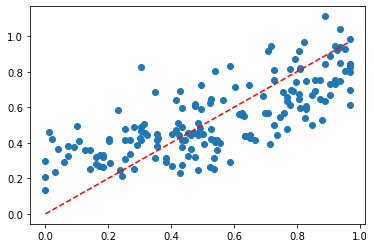

In [361]:
plt.scatter(Graphene_Yield, y_pred)
mid_line = list(np.linspace(np.min(GY_ALL), np.max(GY_ALL), 8))
plt.plot(mid_line, mid_line, '--', color='red')

In [373]:
lowaccur_samples = []

In [374]:
lowaccur_samples

[]

In [375]:
df.iloc[lowaccur_samples]

,Sample,Material,Atmosphere,Mass,Tube Diam,Pretreat_voltage,Pretreat_highest,Voltage,PulseTime,Res_Volt,...,Graphene_Yield,TwoDtoG,DtoG,FWHM 2D,Norm_charge_tot,Norm_I_Max,charge_density,Final_Current_Percent,errors,Graphene_Yield_per


RMSE for test,  14.9328165
time for 100 of split and 1 rep. is: 9.402693271636963


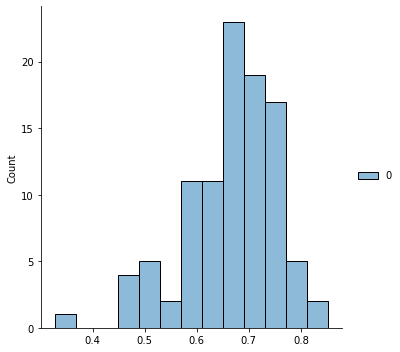

In [376]:
r_squareds = list()
r_squareds_randomized_testtrain = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
r2_max = 0
test_split_seed1 = 0
test_split_seed2 = 100
test_split_count = test_split_seed2 - test_split_seed1
rep = 1
for rand in range (test_split_seed1, test_split_seed2):
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, 100*Graphene_Yield, 
                                       indices, test_size = 0.2, random_state=rand
                                       ,stratify=df['Material']
                                       )
    r_squareds = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    for random_state in range(rep):
        # Instantiate model with 1000 decision trees
        xgbr_graphyield = XGBRegressor(max_depth=3, n_estimators=25, gamma=0.7, 
                   learning_rate=0.118, subsample=0.725, min_child_weight=6, 
                   random_state=random_state)   
        
        # Train the model on training data
        xgbr_graphyield.fit(train_new_features, train_labels);
        # Use the forest's predict method on the test data
        predictions = xgbr_graphyield.predict(test_new_features)
        # Calculate the absolute errors
        errors = abs(predictions - test_labels)
        MAEs.append(errors)
        # Print out the mean absolute error (mae)
        #print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

        r_squared = r2_score(test_labels, predictions)
        r_squareds.append (r_squared)
    
        pred_train = xgbr_graphyield.predict(train_new_features)
        errors = abs(pred_train - train_labels)
        MAEs_train.append(errors)
        r_squared = r2_score(train_labels, pred_train)
        r_squareds_train.append(r_squared)
        #print('r2 score = ', r_squared)
    #print ('test split rand', rand)
    #print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
    #print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

    #print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
    #print ('std of r_squared for train', np.std(np.array(r_squareds_train)))
    # train accuracy
    pred_train = xgbr_graphyield.predict(train_new_features)
    # Calculate the absolute errors
    errors_train = abs(pred_train - train_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error:', round(np.mean(errors_train), 4), 'units.')
    r_squared_train = r2_score(train_labels, pred_train)
    #print('r2 score = ', r_squared_train)
    #print ('time is: ', end-start)

    pred_test = xgbr_graphyield.predict(test_new_features)
    # Calculate the absolute errors
    errors_test = abs(pred_test - test_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error for test:', round(np.mean(errors_test), 4), 'units.')
    r_squared_test = r2_score(test_labels, pred_test)
    if r_squared_test>r2_max:
        r2_max = r_squared_test
        rand_split = rand
    #print('r2 score = ', r_squared_test)
    #print ('****')

    #sns.displot(r_squareds)
    labels = 100*Graphene_Yield
    predictions = xgbr_graphyield.predict(new_features)
    errors_all = (predictions.reshape(-1, 1) - labels)
    r_squareds_randomized_testtrain.append (r_squareds)
    lowaccur_sample = list(np.where(abs(errors_all) > 20))[0]
    for i in lowaccur_sample:
        if i not in lowaccur_samples:
            lowaccur_samples.append(i)
        df.iloc[lowaccur_samples]
    

m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(pred_test, test_labels)
print ('RMSE for test, ', m.result().numpy())
end = time.time()
print ('time for {} of split and {} rep. is: {}'.format(test_split_count, rep, end-start))
r_squareds_randomized_testtrain_vec = np.array ((r_squareds_randomized_testtrain))
r_squareds_randomized_testtrain_mean = np.mean (r_squareds_randomized_testtrain_vec, axis=1)
r_squareds_randomized_testtrain_mean
sns.displot (r_squareds_randomized_testtrain_vec)

In [379]:
print ('indeces of bad samples: ', lowaccur_samples)

# remove bad samples from 174 samples
id_all = list(range(0, 174))
res = [i for i in id_all if i not in lowaccur_samples]

indeces of bad samples:  [2, 9, 12, 14, 20, 47, 48, 52, 58, 77, 82, 85, 89, 97, 99, 112, 152, 169, 61, 64, 73, 102, 138, 167, 65, 134, 168, 6, 78, 104, 46, 72, 80, 135, 140, 144, 35, 1, 98, 108, 26, 145, 19, 70, 133, 136, 7, 13, 164, 62, 118, 151, 162, 121, 114, 75, 94, 53, 17, 160, 142, 147, 60, 42, 161, 76, 54, 0, 34, 27, 155, 37, 28, 57, 131]


In [380]:
len(lowaccur_samples)

75

In [381]:
len(res)

99

RMSE for test,  11.860668
time for 100 of split and 2 rep. is: 17.613746881484985


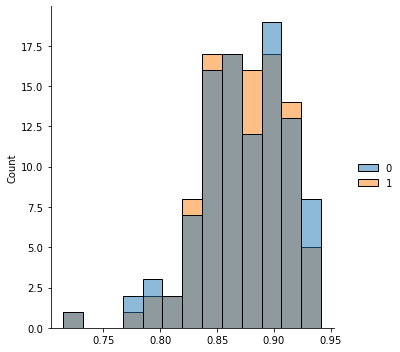

In [382]:
r_squareds = list()
r_squareds_randomized_testtrain = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
r2_max = 0
test_split_seed1 = 0
test_split_seed2 = 100
test_split_count = test_split_seed2 - test_split_seed1
rep = 2
for rand in range (test_split_seed1, test_split_seed2):
    indices = np.arange(len(new_features[res, :]))
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features[res, :], 100*Graphene_Yield[res, :], 
                                       indices, test_size = 0.2, random_state=rand
                                       #,stratify=df.iloc[res]['Material']
                                       )
    r_squareds = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    for random_state in range(rep):
        # Instantiate model with 1000 decision trees
        xgbr_graphyield = XGBRegressor(max_depth=3, n_estimators=25, gamma=0.7, 
                   learning_rate=0.118, subsample=0.725, min_child_weight=6, 
                   random_state=random_state)   
        
        # Train the model on training data
        xgbr_graphyield.fit(train_new_features, train_labels);
        # Use the forest's predict method on the test data
        predictions = xgbr_graphyield.predict(test_new_features)
        # Calculate the absolute errors
        errors = abs(predictions - test_labels)
        MAEs.append(errors)
        # Print out the mean absolute error (mae)
        #print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

        r_squared = r2_score(test_labels, predictions)
        r_squareds.append (r_squared)
    
        pred_train = xgbr_graphyield.predict(train_new_features)
        errors = abs(pred_train - train_labels)
        MAEs_train.append(errors)
        r_squared = r2_score(train_labels, pred_train)
        r_squareds_train.append(r_squared)
        #print('r2 score = ', r_squared)
    #print ('test split rand', rand)
    #print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
    #print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

    #print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
    #print ('std of r_squared for train', np.std(np.array(r_squareds_train)))
    # train accuracy
    pred_train = xgbr_graphyield.predict(train_new_features)
    # Calculate the absolute errors
    errors_train = abs(pred_train - train_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error:', round(np.mean(errors_train), 4), 'units.')
    r_squared_train = r2_score(train_labels, pred_train)
    #print('r2 score = ', r_squared_train)
    #print ('time is: ', end-start)

    pred_test = xgbr_graphyield.predict(test_new_features)
    # Calculate the absolute errors
    errors_test = abs(pred_test - test_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error for test:', round(np.mean(errors_test), 4), 'units.')
    r_squared_test = r2_score(test_labels, pred_test)
    if r_squared_test>r2_max:
        r2_max = r_squared_test
        rand_split = rand
    #print('r2 score = ', r_squared_test)
    #print ('****')

    #sns.displot(r_squareds)
    labels = 100*Graphene_Yield
    predictions = xgbr_graphyield.predict(new_features)
    errors_all = (predictions.reshape(-1, 1) - labels)
    r_squareds_randomized_testtrain.append (r_squareds)
    lowaccur_sample = list(np.where(abs(errors_all) > 45))[0]
    for i in lowaccur_sample:
        if i not in lowaccur_samples:
            lowaccur_samples.append(i)
        df.iloc[lowaccur_samples]
    

m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(pred_test, test_labels)
print ('RMSE for test, ', m.result().numpy())
end = time.time()
print ('time for {} of split and {} rep. is: {}'.format(test_split_count, rep, end-start))
r_squareds_randomized_testtrain_vec = np.array ((r_squareds_randomized_testtrain))
r_squareds_randomized_testtrain_mean = np.mean (r_squareds_randomized_testtrain_vec, axis=1)
r_squareds_randomized_testtrain_mean
sns.displot (r_squareds_randomized_testtrain_vec)

In [383]:
np.where (r_squareds_randomized_testtrain_vec>0.82)

(array([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  8,  8,  9,
        10, 10, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 17, 17, 18, 18, 19,
        19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 26, 26, 27, 27, 28,
        28, 29, 29, 30, 30, 32, 32, 33, 33, 34, 34, 35, 35, 37, 37, 38, 38,
        39, 39, 40, 40, 41, 41, 42, 42, 43, 43, 44, 44, 45, 45, 46, 46, 47,
        47, 48, 48, 49, 49, 50, 50, 51, 51, 52, 52, 53, 53, 54, 54, 55, 55,
        56, 56, 57, 57, 58, 58, 59, 59, 60, 60, 61, 61, 62, 62, 63, 63, 64,
        64, 66, 66, 67, 67, 68, 68, 69, 69, 70, 70, 71, 71, 72, 72, 73, 73,
        74, 74, 75, 75, 76, 76, 77, 77, 78, 79, 79, 80, 80, 81, 81, 82, 82,
        83, 83, 84, 84, 85, 85, 86, 86, 87, 87, 88, 88, 89, 89, 90, 90, 91,
        91, 92, 92, 93, 93, 94, 94, 95, 95, 96, 96, 97, 97, 98, 98, 99]),
 array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 1, 0, 1

In [384]:
r_squareds_randomized_testtrain_vec

array([[0.9030592 , 0.89964716],
       [0.88136773, 0.87458157],
       [0.86815829, 0.83306133],
       [0.84350905, 0.84067221],
       [0.85685255, 0.86373099],
       [0.8389346 , 0.83081058],
       [0.90004019, 0.90226731],
       [0.77057467, 0.79631179],
       [0.84872504, 0.83942173],
       [0.78580881, 0.83856407],
       [0.90652464, 0.90291248],
       [0.8059225 , 0.8350012 ],
       [0.87843723, 0.85784999],
       [0.90672309, 0.90695985],
       [0.90138403, 0.92787476],
       [0.89483664, 0.86118462],
       [0.8231602 , 0.77373261],
       [0.82095795, 0.84346005],
       [0.85051827, 0.89153603],
       [0.91825331, 0.91484697],
       [0.85298501, 0.87488713],
       [0.83028538, 0.85802758],
       [0.86613224, 0.88675599],
       [0.91902542, 0.91585448],
       [0.90159016, 0.88570396],
       [0.79795081, 0.83244064],
       [0.84588676, 0.8420374 ],
       [0.92604658, 0.91306693],
       [0.85403653, 0.86671708],
       [0.85498283, 0.85757535],
       [0.

In [387]:
print (np.mean(r_squareds_randomized_testtrain_vec))
print ('sd of random runs', np.sqrt(np.var(r_squareds_randomized_testtrain_vec)))

0.8728118024684648
sd of random runs 0.03860280131888368


In [395]:
errors_all[res].shape

(99, 1)

In [401]:
df_acc_Pred = df.iloc[res]
df_acc_Pred.to_csv('Accurate_pred_FJH_ML.csv', index=False)

In [438]:
df_acc_Pred

,Sample,Material,Atmosphere,Mass,Tube Diam,Pretreat_voltage,Pretreat_highest,Voltage,PulseTime,Res_Volt,...,Graphene_Yield,TwoDtoG,DtoG,FWHM 2D,Norm_charge_tot,Norm_I_Max,charge_density,Final_Current_Percent,errors,Graphene_Yield_per
3,4,CB,vac,200.0,8,320,80,235,900,43.0,...,0.793651,0.763019,0.661025,50.596165,86.790377,513.726500,112.800000,0.099584,1.091052,79.365079
4,5,CB,air,187.0,8,60,60,145,125,104.6,...,0.253968,0.646567,0.500579,40.277124,19.643746,375.748930,74.438503,0.216167,-7.795663,25.396825
5,6,CB,vac,200.0,8,320,80,235,200,110.0,...,0.873016,0.837778,0.403399,52.679499,56.593311,706.698000,112.800000,0.199556,-2.785291,87.301587
8,9,CB,vac,300.0,8,360,120,220,500,126.0,...,0.968254,0.882534,0.682294,52.908493,45.736935,641.812667,134.933333,0.067043,-10.872142,96.825397
10,11,CB,vac,300.0,8,360,120,240,300,31.0,...,0.936508,0.866697,0.620628,48.677966,112.357137,1622.590333,161.600000,0.031928,-13.063460,93.650794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,167,TCB,vac,276.0,8,240,80,175,340,78.6,...,0.631579,0.537182,0.584564,48.202700,61.163196,860.993116,95.108696,0.074946,7.377002,63.157895
170,171,TCB,vac,321.0,8,210,70,160,430,56.0,...,0.636364,0.631814,0.721581,32.193091,56.169822,676.011215,47.850467,0.096532,-9.408897,63.636364
171,172,TCB,vac,345.0,8,200,100,150,530,32.0,...,0.500000,0.542554,0.633724,43.684705,59.515878,413.002609,57.391304,0.068991,-1.932110,50.000000
172,173,TCB,air,275.0,8,200,100,170,390,33.0,...,0.471910,0.562038,0.547242,47.415184,87.632616,864.124000,37.090909,0.067037,0.782164,47.191011


In [410]:
df_acc_Pred.loc[df_acc_Pred['Sample']==102] 
#+ df_acc_Pred.loc[df_acc_Pred['Sample']==46]

,Sample,Material,Atmosphere,Mass,Tube Diam,Pretreat_voltage,Pretreat_highest,Voltage,PulseTime,Res_Volt,...,Graphene_Yield,TwoDtoG,DtoG,FWHM 2D,Norm_charge_tot,Norm_I_Max,charge_density,Final_Current_Percent,errors,Graphene_Yield_per
101,102,PA,vac,237.0,8,200,100,189,332,62.7,...,0.848485,0.730785,0.479065,43.306916,70.782939,1397.695359,119.620253,0.042024,-6.621808,84.848485


In [571]:
df_test_new = pd.DataFrame(columns=['Sample',"CB_per", "MC_per", "PA_per",
                                "TCB_per", "Atmosphere_type", "Mass", "Pretreat_voltage",
                                "Voltage","PulseTime", "Cap"])
df_test_new['Sample'] = list(range(0, 12))
df_test_new['CB_per'] = 0 
df_test_new['MC_per'] = 0
df_test_new['PA_per'] = 0
df_test_new['TCB_per'] = 0 

In [572]:
# !!!! Sample 0: samples 46 + 102
id0_1 = 46
id0_2 = 102
sam0_1 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_1]
print (sam0_1['Material']) 
sam0_2 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_2]
print (sam0_2['Material'])

df_test_new.loc[0, ('{}_per'.format(sam0_1.iloc[0]['Material']))] = 0.5
df_test_new.loc[0, ('{}_per'.format(sam0_2.iloc[0]['Material']))] = 0.5

df_test_new.loc[0, ('Cap')] = int((sam0_1.iloc[0]['Cap'] + sam0_2.iloc[0]['Cap'])/2)
df_test_new.loc[0, ('PulseTime')] = int((sam0_1.iloc[0]['PulseTime'] + sam0_2.iloc[0]['PulseTime'])/2)
df_test_new.loc[0, ('Voltage')] = int ((sam0_1.iloc[0]['Voltage'] + sam0_2.iloc[0]['Voltage'])/2)
df_test_new.loc[0, ('Pretreat_voltage')] = int((sam0_1.iloc[0]['Pretreat_voltage'] + 
                                            sam0_2.iloc[0]['Pretreat_voltage'])/2)
df_test_new.loc[0, ('Mass')] = int ((sam0_1.iloc[0]['Mass'] + sam0_2.iloc[0]['Mass'])/2)
df_test_new.loc[0, ('Atmosphere_type')] = sam0_1.iloc[0]['Atmosphere']

45    CB
Name: Material, dtype: object
101    PA
Name: Material, dtype: object


In [573]:
# !!!! Sample 1: samples 40 + 104
id0_1 = 40
id0_2 = 104
sam0_1 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_1]
print (sam0_1['Material']) 
sam0_2 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_2]
print (sam0_2['Material'])

df_test_new.loc[1, ('{}_per'.format(sam0_1.iloc[0]['Material']))] = 0.5
df_test_new.loc[1, ('{}_per'.format(sam0_2.iloc[0]['Material']))] = 0.5

df_test_new.loc[1, ('Cap')] = int ((sam0_1.iloc[0]['Cap'] + sam0_2.iloc[0]['Cap'])/2)
df_test_new.loc[1, ('PulseTime')] = int ((sam0_1.iloc[0]['PulseTime'] + sam0_2.iloc[0]['PulseTime'])/2)
df_test_new.loc[1, ('Voltage')] = int ((sam0_1.iloc[0]['Voltage'] + sam0_2.iloc[0]['Voltage'])/2)
df_test_new.loc[1, ('Pretreat_voltage')] = int ((sam0_1.iloc[0]['Pretreat_voltage'] + 
                                            sam0_2.iloc[0]['Pretreat_voltage'])/2)
df_test_new.loc[1, ('Mass')] = int ((sam0_1.iloc[0]['Mass'] + sam0_2.iloc[0]['Mass'])/2)
df_test_new.loc[1, ('Atmosphere_type')] = sam0_1.iloc[0]['Atmosphere']

39    CB
Name: Material, dtype: object
103    PA
Name: Material, dtype: object


In [574]:
# !!!! Sample 2: samples 
id0_1 = 112
id0_2 = 166
sam0_1 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_1]
print (sam0_1['Material']) 
sam0_2 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_2]
print (sam0_2['Material'])

df_test_new.loc[2,('{}_per'.format(sam0_1.iloc[0]['Material']))] = 0.5
df_test_new.loc[2,('{}_per'.format(sam0_2.iloc[0]['Material']))] = 0.5

df_test_new.loc[2,('Cap')] = int ((sam0_1.iloc[0]['Cap'] + sam0_2.iloc[0]['Cap'])/2)
df_test_new.loc[2,('PulseTime')] = int ((sam0_1.iloc[0]['PulseTime'] + sam0_2.iloc[0]['PulseTime'])/2)
df_test_new.loc[2,('Voltage')] = int ((sam0_1.iloc[0]['Voltage'] + sam0_2.iloc[0]['Voltage'])/2)
df_test_new.loc[2,('Pretreat_voltage')] = int ((sam0_1.iloc[0]['Pretreat_voltage'] + 
                                            sam0_2.iloc[0]['Pretreat_voltage'])/2)
df_test_new.loc[2,('Mass')] = int ((sam0_1.iloc[0]['Mass'] + sam0_2.iloc[0]['Mass'])/2)
df_test_new.loc[2,('Atmosphere_type')] = sam0_1.iloc[0]['Atmosphere']

111    PA
Name: Material, dtype: object
165    TCB
Name: Material, dtype: object


In [575]:
# !!!! Sample 3: samples 
id0_1 = 159
id0_2 = 57
sam0_1 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_1]
print (sam0_1['Material']) 
sam0_2 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_2]
print (sam0_2['Material'])

df_test_new.loc[3,('{}_per'.format(sam0_1.iloc[0]['Material']))] = 0.5
df_test_new.loc[3,('{}_per'.format(sam0_2.iloc[0]['Material']))] = 0.5

df_test_new.loc[3,('Cap')] = int ((sam0_1.iloc[0]['Cap'] + sam0_2.iloc[0]['Cap'])/2)
df_test_new.loc[3,('PulseTime')] = int ((sam0_1.iloc[0]['PulseTime'] + sam0_2.iloc[0]['PulseTime'])/2)
df_test_new.loc[3,('Voltage')] = int ((sam0_1.iloc[0]['Voltage'] + sam0_2.iloc[0]['Voltage'])/2)
df_test_new.loc[3,('Pretreat_voltage')] = int ((sam0_1.iloc[0]['Pretreat_voltage'] + 
                                            sam0_2.iloc[0]['Pretreat_voltage'])/2)
df_test_new.loc[3,('Mass')] = int ((sam0_1.iloc[0]['Mass'] + sam0_2.iloc[0]['Mass'])/2)
df_test_new.loc[3,('Atmosphere_type')] = sam0_1.iloc[0]['Atmosphere']

158    TCB
Name: Material, dtype: object
56    CB
Name: Material, dtype: object


In [576]:
# !!!! Sample 4: samples 
id0_1 = 75
id0_2 = 89
sam0_1 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_1]
print (sam0_1['Material']) 
sam0_2 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_2]
print (sam0_2['Material'])

df_test_new.loc[4,('{}_per'.format(sam0_1.iloc[0]['Material']))] = 0.5
df_test_new.loc[4,('{}_per'.format(sam0_2.iloc[0]['Material']))] = 0.5

df_test_new.loc[4,('Cap')] = int ((sam0_1.iloc[0]['Cap'] + sam0_2.iloc[0]['Cap'])/2)
df_test_new.loc[4,('PulseTime')] = int ((sam0_1.iloc[0]['PulseTime'] + sam0_2.iloc[0]['PulseTime'])/2)
df_test_new.loc[4,('Voltage')] = int ((sam0_1.iloc[0]['Voltage'] + sam0_2.iloc[0]['Voltage'])/2)
df_test_new.loc[4,('Pretreat_voltage')] = int ((sam0_1.iloc[0]['Pretreat_voltage'] + 
                                            sam0_2.iloc[0]['Pretreat_voltage'])/2)
df_test_new.loc[4,('Mass')] = int ((sam0_1.iloc[0]['Mass'] + sam0_2.iloc[0]['Mass'])/2)
df_test_new.loc[4,('Atmosphere_type')] = sam0_1.iloc[0]['Atmosphere']

74    MC
Name: Material, dtype: object
88    PA
Name: Material, dtype: object


In [577]:
# !!!! Sample 5: samples 
id0_1 = 172
id0_2 = 67
sam0_1 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_1]
print (sam0_1['Material']) 
sam0_2 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_2]
print (sam0_2['Material'])

df_test_new.loc[5,('{}_per'.format(sam0_1.iloc[0]['Material']))] = 0.5
df_test_new.loc[5,('{}_per'.format(sam0_2.iloc[0]['Material']))] = 0.5

df_test_new.loc[5,('Cap')] = int ((sam0_1.iloc[0]['Cap'] + sam0_2.iloc[0]['Cap'])/2)
df_test_new.loc[5,('PulseTime')] = int ((sam0_1.iloc[0]['PulseTime'] + sam0_2.iloc[0]['PulseTime'])/2)
df_test_new.loc[5,('Voltage')] = int ((sam0_1.iloc[0]['Voltage'] + sam0_2.iloc[0]['Voltage'])/2)
df_test_new.loc[5,('Pretreat_voltage')] = int ((sam0_1.iloc[0]['Pretreat_voltage'] + 
                                            sam0_2.iloc[0]['Pretreat_voltage'])/2)
df_test_new.loc[5,('Mass')] = int ((sam0_1.iloc[0]['Mass'] + sam0_2.iloc[0]['Mass'])/2)
df_test_new.loc[5,('Atmosphere_type')] = sam0_1.iloc[0]['Atmosphere']

171    TCB
Name: Material, dtype: object
66    MC
Name: Material, dtype: object


In [578]:
# !!!! Sample 6: samples 
id0_1 = 51
id0_2 = 121
sam0_1 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_1]
print (sam0_1['Material']) 
sam0_2 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_2]
print (sam0_2['Material'])

df_test_new.loc[6,('{}_per'.format(sam0_1.iloc[0]['Material']))] = 0.5
df_test_new.loc[6,('{}_per'.format(sam0_2.iloc[0]['Material']))] = 0.5

df_test_new.loc[6,('Cap')] = int ((sam0_1.iloc[0]['Cap'] + sam0_2.iloc[0]['Cap'])/2)
df_test_new.loc[6,('PulseTime')] = int ((sam0_1.iloc[0]['PulseTime'] + sam0_2.iloc[0]['PulseTime'])/2)
df_test_new.loc[6,('Voltage')] = int ((sam0_1.iloc[0]['Voltage'] + sam0_2.iloc[0]['Voltage'])/2)
df_test_new.loc[6,('Pretreat_voltage')] = int ((sam0_1.iloc[0]['Pretreat_voltage'] + 
                                            sam0_2.iloc[0]['Pretreat_voltage'])/2)
df_test_new.loc[6,('Mass')] = int ((sam0_1.iloc[0]['Mass'] + sam0_2.iloc[0]['Mass'])/2)
df_test_new.loc[6,('Atmosphere_type')] = sam0_1.iloc[0]['Atmosphere']

50    CB
Name: Material, dtype: object
120    MC
Name: Material, dtype: object


In [579]:
# !!!! Sample 7: samples 
id0_1 = 94
id0_2 = 44
sam0_1 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_1]
print (sam0_1['Material']) 
sam0_2 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_2]
print (sam0_2['Material'])

df_test_new.loc[7,('{}_per'.format(sam0_1.iloc[0]['Material']))] = 0.5
df_test_new.loc[7,('{}_per'.format(sam0_2.iloc[0]['Material']))] = 0.5

df_test_new.loc[7,('Cap')] = int ((sam0_1.iloc[0]['Cap'] + sam0_2.iloc[0]['Cap'])/2)
df_test_new.loc[7,('PulseTime')] = int ((sam0_1.iloc[0]['PulseTime'] + sam0_2.iloc[0]['PulseTime'])/2)
df_test_new.loc[7,('Voltage')] = int ((sam0_1.iloc[0]['Voltage'] + sam0_2.iloc[0]['Voltage'])/2)
df_test_new.loc[7,('Pretreat_voltage')] = int ((sam0_1.iloc[0]['Pretreat_voltage'] + 
                                            sam0_2.iloc[0]['Pretreat_voltage'])/2)
df_test_new.loc[7,('Mass')] = int ((sam0_1.iloc[0]['Mass'] + sam0_2.iloc[0]['Mass'])/2)
df_test_new.loc[7,('Atmosphere_type')] = sam0_1.iloc[0]['Atmosphere']

93    PA
Name: Material, dtype: object
43    CB
Name: Material, dtype: object


In [580]:
# !!!! Sample 8: samples 
id0_1 = 140
id0_2 = 44
sam0_1 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_1]
print (sam0_1['Material']) 
sam0_2 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_2]
print (sam0_2['Material'])

df_test_new.loc[8,('{}_per'.format(sam0_1.iloc[0]['Material']))] = 0.5
df_test_new.loc[8,('{}_per'.format(sam0_2.iloc[0]['Material']))] = 0.5

df_test_new.loc[8,('Cap')] = int ((sam0_1.iloc[0]['Cap'] + sam0_2.iloc[0]['Cap'])/2)
df_test_new.loc[8,('PulseTime')] = int ((sam0_1.iloc[0]['PulseTime'] + sam0_2.iloc[0]['PulseTime'])/2)
df_test_new.loc[8,('Voltage')] = int ((sam0_1.iloc[0]['Voltage'] + sam0_2.iloc[0]['Voltage'])/2)
df_test_new.loc[8,('Pretreat_voltage')] = int ((sam0_1.iloc[0]['Pretreat_voltage'] + 
                                            sam0_2.iloc[0]['Pretreat_voltage'])/2)
df_test_new.loc[8,('Mass')] = int ((sam0_1.iloc[0]['Mass'] + sam0_2.iloc[0]['Mass'])/2)
df_test_new.loc[8,('Atmosphere_type')] = sam0_1.iloc[0]['Atmosphere']

139    TCB
Name: Material, dtype: object
43    CB
Name: Material, dtype: object


In [581]:
# !!!! Sample 9: samples 
id0_1 = 85
id0_2 = 127
sam0_1 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_1]
print (sam0_1['Material']) 
sam0_2 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_2]
print (sam0_2['Material'])

df_test_new.loc[9,('{}_per'.format(sam0_1.iloc[0]['Material']))] = 0.5
df_test_new.loc[9,('{}_per'.format(sam0_2.iloc[0]['Material']))] = 0.5

df_test_new.loc[9,('Cap')] = int ((sam0_1.iloc[0]['Cap'] + sam0_2.iloc[0]['Cap'])/2)
df_test_new.loc[9,('PulseTime')] = int ((sam0_1.iloc[0]['PulseTime'] + sam0_2.iloc[0]['PulseTime'])/2)
df_test_new.loc[9,('Voltage')] = int ((sam0_1.iloc[0]['Voltage'] + sam0_2.iloc[0]['Voltage'])/2)
df_test_new.loc[9,('Pretreat_voltage')] = int ((sam0_1.iloc[0]['Pretreat_voltage'] + 
                                            sam0_2.iloc[0]['Pretreat_voltage'])/2)
df_test_new.loc[9,('Mass')] = int ((sam0_1.iloc[0]['Mass'] + sam0_2.iloc[0]['Mass'])/2)
df_test_new.loc[9,('Atmosphere_type')] = sam0_1.iloc[0]['Atmosphere']

84    PA
Name: Material, dtype: object
126    MC
Name: Material, dtype: object


In [585]:
# !!!! Sample 10: samples 
id0_1 = 37
id0_2 = 107
sam0_1 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_1]
print (sam0_1['Material']) 
sam0_2 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_2]
print (sam0_2['Material'])

df_test_new.loc[10,('{}_per'.format(sam0_1.iloc[0]['Material']))] = 0.5
df_test_new.loc[10,('{}_per'.format(sam0_2.iloc[0]['Material']))] = 0.5

df_test_new.loc[10,('Cap')] = int ((sam0_1.iloc[0]['Cap'] + sam0_2.iloc[0]['Cap'])/2)
df_test_new.loc[10,('PulseTime')] = int ((sam0_1.iloc[0]['PulseTime'] + sam0_2.iloc[0]['PulseTime'])/2)
df_test_new.loc[10,('Voltage')] = int ((sam0_1.iloc[0]['Voltage'] + sam0_2.iloc[0]['Voltage'])/2)
df_test_new.loc[10,('Pretreat_voltage')] = int ((sam0_1.iloc[0]['Pretreat_voltage'] + 
                                            sam0_2.iloc[0]['Pretreat_voltage'])/2)
df_test_new.loc[10,('Mass')] = int ((sam0_1.iloc[0]['Mass'] + sam0_2.iloc[0]['Mass'])/2)
df_test_new.loc[10,('Atmosphere_type')] = sam0_1.iloc[0]['Atmosphere']

36    CB
Name: Material, dtype: object
106    PA
Name: Material, dtype: object


In [ ]:
# !!!! Sample 11: samples 
id0_1 = 37
id0_2 = 17
sam0_1 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_1]
print (sam0_1['Material']) 
sam0_2 = df_acc_Pred.loc[df_acc_Pred['Sample']==id0_2]
print (sam0_2['Material'])

df_test_new.loc[11,('{}_per'.format(sam0_1.iloc[0]['Material']))] = 0.5
df_test_new.loc[11,('{}_per'.format(sam0_2.iloc[0]['Material']))] = 0.5

df_test_new.loc[11,('Cap')] = int ((sam0_1.iloc[0]['Cap'] + sam0_2.iloc[0]['Cap'])/2)
df_test_new.loc[11,('PulseTime')] = int ((sam0_1.iloc[0]['PulseTime'] + sam0_2.iloc[0]['PulseTime'])/2)
df_test_new.loc[11,('Voltage')] = int ((sam0_1.iloc[0]['Voltage'] + sam0_2.iloc[0]['Voltage'])/2)
df_test_new.loc[11,('Pretreat_voltage')] = int ((sam0_1.iloc[0]['Pretreat_voltage'] + 
                                            sam0_2.iloc[0]['Pretreat_voltage'])/2)
df_test_new.loc[11,('Mass')] = int ((sam0_1.iloc[0]['Mass'] + sam0_2.iloc[0]['Mass'])/2)
df_test_new.loc[11,('Atmosphere_type')] = sam0_1.iloc[0]['Atmosphere']

In [584]:
sam0_1

,Sample,Material,Atmosphere,Mass,Tube Diam,Pretreat_voltage,Pretreat_highest,Voltage,PulseTime,Res_Volt,...,Graphene_Yield,TwoDtoG,DtoG,FWHM 2D,Norm_charge_tot,Norm_I_Max,charge_density,Final_Current_Percent,errors,Graphene_Yield_per
36,37,CB,arg,156.3,8,240,100,190,70,129.0,...,0.79798,0.843329,0.534587,46.486896,42.551962,1175.65579,138.579655,0.361239,-4.771437,79.79798


In [586]:
df_test_new

,Sample,CB_per,MC_per,PA_per,TCB_per,Atmosphere_type,Mass,Pretreat_voltage,Voltage,PulseTime,Cap
0,0,0.5,0.0,0.5,0.0,vac,196,190,189,466,123
1,1,0.5,0.0,0.5,0.0,vac,184,265,207,109,132
2,2,0.0,0.0,0.5,0.5,vac,334,220,214,451,141
3,3,0.5,0.0,0.0,0.5,vac,219,232,199,386,132
4,4,0.0,0.5,0.5,0.0,vac,261,257,225,241,105
5,5,0.0,0.5,0.0,0.5,vac,264,150,185,353,132
6,6,0.5,0.5,0.0,0.0,vac,252,155,185,117,114
7,7,0.5,0.0,0.5,0.0,vac,279,120,125,90,60
8,8,0.5,0.0,0.0,0.5,vac,300,102,159,74,105
9,9,0.0,0.5,0.5,0.0,vac,330,210,185,338,141


In [435]:
sam1_1['Sample']

45    46
Name: Sample, dtype: int64

In [416]:
df_test.shape

(0, 2)

In [ ]:
print ('End!!!')